# Plot spider


In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

from local_python.general_utils import load_pd_from_json, select_and_sort_dataframe
from local_python.radar_chart import radar_factory

In [2]:
metric_name = "f1_macro"
aggregating_functions = ["mean", "std", "count"]
metric_file_root_path = "../runs/"

In [3]:
def number_to_string(value):
    if str(value) != "nan" and value != value and value is not None:
        return str(int(value))
    else:  # NaN
        return "All"


def get_downstream(value):
    return get_feature_identifier_part(value, 0).replace("_", "-")


def get_architecture(value):
    return get_feature_identifier_part(value, 1)


name_map = {
    "Random": "Random",
    "ImageNet_1k_SL_WinKawaks": "ImageNet SL",
    "ImageNet_1k_SL_V1": "ImageNet SL",
    "ImageNet_1k_SSL_Dino": "ImageNet SSL",
    "ImageNet_1k_SSL_SimCLR": "ImageNet SSL",
    "ImageNet_AugReg": "ImageNet AR",
    "Derma": "Derma SSL",
    "Derma_SSL_SimCLR": "Derma SSL",
    "PDDD": "Plant SL",
    "Plant": "Plant SSL",
}


def get_pretraining(value):
    return name_map[get_feature_identifier_part(value, 2)]


def get_feature_identifier_part(value, idx):
    return os.path.splitext(os.path.basename(value))[0].split("-")[idx]


def get_classifier(value):
    if value == "lr":
        return "lin."
    elif value == "knn":
        return "k-NN"
    else:
        return value


def score_to_percent_string(values):
    (mean, std, count) = values
    mean_str = "%.1f" % (100 * mean)
    std_err_str = "%.1f" % (100 * std / np.sqrt(count))
    return f"{mean_str}±{std_err_str}"


def aggregate_and_save(metric_file_path, csv_path):
    df_full = load_pd_from_json(metric_file_path)
    assert 1 == len(df_full["number_of_samples"].unique())
    df_full["Architecture"] = df_full["feature_identifier"].apply(get_architecture)
    assert 1 == len(df_full["Architecture"].unique())
    df_full["number_of_samples"] = df_full["number_of_samples"].apply(number_to_string)
    df_full["Downstream"] = df_full["feature_identifier"].apply(get_downstream)
    df_full["Downstream"] = pd.Categorical(
        df_full["Downstream"],
        [
            col
            for col in [
                "DDI",
                "PAD-UFES-20",
                "HAM10000",
                "Fitzpatrick17k",
                "PlantDoc",
                "PlantDataset",
                "Cassava",
                "PlantVillage",
            ]
            if col in df_full["Downstream"].unique()
        ],
    )
    df_full["Pre-training"] = df_full["feature_identifier"].apply(get_pretraining)
    df_full["Pre-training"] = pd.Categorical(
        df_full["Pre-training"],
        [
            col
            for col in [
                "Random",
                "ImageNet SL",
                "ImageNet SSL",
                "ImageNet AR",
                "Derma SSL",
                "Plant SL",
                "Plant SSL",
            ]
            if col in df_full["Pre-training"].unique()
        ],
    )
    df_full["Classifier"] = df_full["model_name"].apply(get_classifier)
    df_groups = df_full.groupby(["Pre-training", "Classifier", "Downstream"]).agg(
        {metric_name: aggregating_functions}
    )
    df = (
        df_groups[metric_name][aggregating_functions]
        .apply(score_to_percent_string, axis=1)
        .unstack(level=-1)
        .unstack(level=-1)
    )
    df.to_csv(csv_path)
    return df

In [4]:
df_full = aggregate_and_save(
    "../runs/master-metrics-resnet-derma.txt", "../results/f1_scores_resnet_derma.csv"
)
df_full = aggregate_and_save(
    "../runs/master-metrics-resnet-plant.txt", "../results/f1_scores_resnet_plant.csv"
)
df_full = aggregate_and_save(
    "../runs/master-metrics-vit-derma.txt", "../results/f1_scores_vit_derma.csv"
)
df_full = aggregate_and_save(
    "../runs/master-metrics-vit-plant.txt", "../results/f1_scores_vit_plant.csv"
)
df_full

Read 400 entries from master-metrics-resnet-derma.txt
Read 400 entries from master-metrics-resnet-plant.txt
Read 480 entries from master-metrics-vit-derma.txt
Read 480 entries from master-metrics-vit-plant.txt


Downstream    PlantDoc           PlantDataset             Cassava            \
Classifier        k-NN      lin.         k-NN      lin.      k-NN      lin.   
Pre-training                                                                  
Random         9.2±0.6   8.9±0.5     22.0±0.5  38.6±0.3  23.9±0.3  26.3±0.1   
ImageNet SL   35.9±0.6  50.1±0.4     81.7±0.6  89.3±0.3  43.7±0.4  58.2±0.2   
ImageNet SSL  39.3±0.6  53.5±0.5     88.7±0.5  93.6±0.3  50.4±0.4  64.4±0.2   
ImageNet AR    9.6±0.8  43.9±0.6     20.4±0.9  79.9±0.5  24.9±0.2  55.8±0.1   
Derma SSL     24.7±0.5  31.4±0.4     79.6±0.3  80.4±0.2  40.0±0.3  54.2±0.1   
Plant SSL     38.8±0.5  54.2±0.6     87.3±0.3  86.7±0.3  49.8±0.2  64.7±0.2   

Downstream   PlantVillage            
Classifier           k-NN      lin.  
Pre-training                         
Random           36.4±0.1  59.4±0.1  
ImageNet SL      94.0±0.1  97.1±0.0  
ImageNet SSL     96.0±0.1  98.2±0.0  
ImageNet AR      62.2±0.2  95.0±0.1  
Derma SSL        96.3±0.1  97.8±0.0  
Plant SSL        99.4±0.0  99.4±0.0

In [5]:
def load_and_add_data(metric_file_paths, selection_config, labels):
    data = []
    for metric_file_path in metric_file_paths:
        df_full = load_pd_from_json(metric_file_path)
        df_full["number_of_samples"] = df_full["number_of_samples"].apply(
            number_to_string
        )
        target_columns = [k for k, v in selection_config.items() if v is None]
        assert 1 == len(
            target_columns
        ), f"Invalid configuration. Exactly 1 key should have (None) as value, but there are {len(target_columns)}"
        group_columns = [
            k for k in selection_config.keys() if not k == target_columns[0]
        ]
        # metric_file_path = os.path.join(
        #     metric_file_root_path, f"{dataset_key}-metrics.txt"
        # )
        for column, dataset_key in enumerate(dataset_configs):
            dataset_label = dataset_configs[dataset_key]
            copied_df = df_full[
                df_full["feature_identifier"].str.contains(dataset_key)
            ].copy()
            if 0 == len(copied_df):
                print(f"dataset_key: {dataset_key}, {metric_file_path}")
                continue
            return_value = select_and_sort_dataframe(copied_df, selection_config)
            selected_values = (
                return_value.groupby(group_columns)[target_columns].mean().values
            )
            if len(labels) != len(selected_values):
                print(
                    f"Number of values do not match {len(labels)} != {len(selected_values)}"
                )
                assert False
            else:
                data.append(selected_values)
    if 0 < len(data):
        columns = dataset_configs.values()
        values = np.transpose(data).reshape((-1, len(columns)))
        df_agg = pd.DataFrame(values, columns=columns)
        df_agg.index = labels
        return df_agg
    else:
        print(f"No data")
        return None

In [6]:
dataset_configs = {
    # "PlantDoc-ResNet50": "PlantDoc", #
    # "PAD_UFES_20-ResNet50": "PAD-UFES-20", #
    # "DDI-ResNet50": "DDI", #
    # "HAM10000-ResNet50": "HAM10000", #
    # "Fitzpatrick17k-ResNet50": "Fitzpatrick17k", #
    # "Cassava-ResNet50": "Cassava", #
    # "PlantVillage-ResNet50": "PlantVillage", #
    # "PlantDataset-ResNet50": "PlantDataset", #
    # "PlantDoc-ViT_T16": "PlantDoc",  #
    # "PAD_UFES_20-ViT_T16": "PAD-UFES-20",  #
    # "DDI-ViT_T16": "DDI",  #
    # "HAM10000-ViT_T16": "HAM10000",  #
    # "Fitzpatrick17k-ViT_T16": "Fitzpatrick17k",  #
    # "Cassava-ViT_T16": "Cassava",  #
    # "PlantVillage-ViT_T16": "PlantVillage",  #
    # "PlantDataset-ViT_T16": "PlantDataset",  #
    "PlantDoc-": "PlantDoc",  #
    "PAD_UFES_20-": "PAD-UFES-20",  #
    "DDI-": "DDI",  #
    "HAM10000-": "HAM10000",  #
    "Fitzpatrick17k-": "Fitzpatrick17k",  #
    "Cassava-": "Cassava",  #
    "PlantVillage-": "PlantVillage",  #
    "PlantDataset-": "PlantDataset",  #
}

In [7]:
selection_config = {"f1_macro": None, "model_name": "dc"}
df_plot_1 = load_and_add_data(
    ["../runs/master-metrics-baseline.txt"], selection_config, labels=["Baseline"]
)
df_plot_1

Read 880 entries from master-metrics-baseline.txt


,PlantDoc,PAD-UFES-20,DDI,HAM10000,Fitzpatrick17k,Cassava,PlantVillage,PlantDataset
Baseline,0.002874,0.089431,0.426087,0.107246,0.281094,0.152315,0.004851,0.017886


In [74]:
labels = [
    "Random",
    # "SL ImageNet",
    "SSL ImageNet",
    "SSL Derma",
    # "SL Plant",
    "SSL Plant",
]
selection_config = {
    "model_name": "knn",
    "number_of_samples": "All",
    "feature_identifier": [
        "-Random",
        # "-ImageNet_1k_SL_V1",
        # "-ImageNet_1k_SL_WinKawaks",
        "-ImageNet_1k_SSL",
        "-ImageNet_1k_SSL_SimCLR",
        "-Derma",
        "-PDDD",
        "-Plant",
    ],  # also used as order
    "f1_macro": None,
}

df_plot_2 = load_and_add_data(
    [
        "../runs/master-metrics-resnet-derma.txt",
        "../runs/master-metrics-resnet-plant.txt",
    ],
    selection_config,
    labels=labels#[f"knn - resnet - {label}" for label in labels],
)

labels = [
    "Random",
    # "SL ImageNet",
    "SSL ImageNet",
    "SSL Derma",
    # "SL Plant",
    "SSL Plant",
]
df_plot_3 = load_and_add_data(
    [
        "../runs/master-metrics-vit-derma.txt",
        "../runs/master-metrics-vit-plant.txt",
    ],
    selection_config,
    labels=labels#[f"knn - vit - {label}" for label in labels],
)

Read 400 entries from master-metrics-resnet-derma.txt
dataset_key: PlantDoc-, ../runs/master-metrics-resnet-derma.txt
dataset_key: Cassava-, ../runs/master-metrics-resnet-derma.txt
dataset_key: PlantVillage-, ../runs/master-metrics-resnet-derma.txt
dataset_key: PlantDataset-, ../runs/master-metrics-resnet-derma.txt
Read 400 entries from master-metrics-resnet-plant.txt
dataset_key: PAD_UFES_20-, ../runs/master-metrics-resnet-plant.txt
dataset_key: DDI-, ../runs/master-metrics-resnet-plant.txt
dataset_key: HAM10000-, ../runs/master-metrics-resnet-plant.txt
dataset_key: Fitzpatrick17k-, ../runs/master-metrics-resnet-plant.txt
Read 480 entries from master-metrics-vit-derma.txt
dataset_key: PlantDoc-, ../runs/master-metrics-vit-derma.txt
dataset_key: Cassava-, ../runs/master-metrics-vit-derma.txt
dataset_key: PlantVillage-, ../runs/master-metrics-vit-derma.txt
dataset_key: PlantDataset-, ../runs/master-metrics-vit-derma.txt
Read 480 entries from master-metrics-vit-plant.txt
dataset_key: PAD

In [76]:
labels = [
    "Random",
    # "SL ImageNet",
    "SSL ImageNet",
    "SSL Derma",
    # "SL Plant",
    "SSL Plant",
]


selection_config["model_name"] = "lr"

df_plot_4 = load_and_add_data(
    [
        "../runs/master-metrics-resnet-derma.txt",
        "../runs/master-metrics-resnet-plant.txt",
    ],
    selection_config,
    labels=labels #[f"lr - resnet - {label}" for label in labels],
)
labels = [
    "Random",
    # "SL ImageNet",
    "SSL ImageNet",
    "SSL Derma",
    # "SL Plant",
    "SSL Plant",
]
df_plot_5 = load_and_add_data(
    [
        "../runs/master-metrics-vit-derma.txt",
        "../runs/master-metrics-vit-plant.txt",
    ],
    selection_config,
    labels=labels #[f"lr - vit - {label}" for label in labels],
)

df_plot = pd.concat(
    [
        # df_plot_1,
        df_plot_2,
        df_plot_3,
        df_plot_4,
        df_plot_5,
    ]
)
df_plot

Read 400 entries from master-metrics-resnet-derma.txt
dataset_key: PlantDoc-, ../runs/master-metrics-resnet-derma.txt
dataset_key: Cassava-, ../runs/master-metrics-resnet-derma.txt
dataset_key: PlantVillage-, ../runs/master-metrics-resnet-derma.txt
dataset_key: PlantDataset-, ../runs/master-metrics-resnet-derma.txt
Read 400 entries from master-metrics-resnet-plant.txt
dataset_key: PAD_UFES_20-, ../runs/master-metrics-resnet-plant.txt
dataset_key: DDI-, ../runs/master-metrics-resnet-plant.txt
dataset_key: HAM10000-, ../runs/master-metrics-resnet-plant.txt
dataset_key: Fitzpatrick17k-, ../runs/master-metrics-resnet-plant.txt
Read 480 entries from master-metrics-vit-derma.txt
dataset_key: PlantDoc-, ../runs/master-metrics-vit-derma.txt
dataset_key: Cassava-, ../runs/master-metrics-vit-derma.txt
dataset_key: PlantVillage-, ../runs/master-metrics-vit-derma.txt
dataset_key: PlantDataset-, ../runs/master-metrics-vit-derma.txt
Read 480 entries from master-metrics-vit-plant.txt
dataset_key: PAD

,PlantDoc,PAD-UFES-20,DDI,HAM10000,Fitzpatrick17k,Cassava,PlantVillage,PlantDataset
Random,0.193263,0.546551,0.223613,0.413341,0.066961,0.239409,0.399076,0.171888
SSL ImageNet,0.301948,0.562051,0.263952,0.443065,0.090162,0.227930,0.346885,0.219812
SSL Derma,0.337347,0.507571,0.285981,0.485961,0.189225,0.277522,0.493156,0.307144
SSL Plant,0.362993,0.528867,0.326172,0.511678,0.413269,0.406015,0.986551,0.605229
Random,0.240112,0.522495,0.231125,0.419089,0.092146,0.239336,0.364322,0.219998
SSL ImageNet,0.463455,0.702120,0.433290,0.706709,0.393468,0.503847,0.960209,0.887206
SSL Derma,0.454482,0.562754,0.476310,0.698083,0.247121,0.399838,0.963382,0.796164
SSL Plant,0.469076,0.624663,0.429341,0.677688,0.387751,0.497698,0.993930,0.872751
Random,0.339427,0.663295,0.338485,0.397891,0.134694,0.315897,0.705471,0.345627
SSL ImageNet,0.352135,0.536142,0.299488,0.356831,0.118702,0.211278,0.500811,0.319557


In [61]:
print(df_plot.idxmax())
print(df_plot.max())
# lr - viz - SSL Derma, knn - vit - SSL Derma
# lr - viz - SL/SSL Plant, knn - vit - SL/SSL Plant, lr - resnet - SL/SSL Plant
# lr - resnet - SL ImageNet, knn - resnet - SL ImageNet
# lr - viz - SSL ImageNet, knn - vit - SSL ImageNet

# lr - viz - SSL ImageNet, knn - vit - SSL ImageNet, lr - resnet - SL ImageNet
# lr - viz - SL/SSL Plant, knn - vit - SL/SSL Plant, lr - resnet - SL/SSL Plant, knn - vit - SSL Derma


PlantDoc          SSL ImageNet
PAD-UFES-20       SSL ImageNet
DDI                  SSL Plant
HAM10000          SSL ImageNet
Fitzpatrick17k    SSL ImageNet
Cassava              SSL Plant
PlantVillage         SSL Plant
PlantDataset      SSL ImageNet
dtype: object
PlantDoc          0.531912
PAD-UFES-20       0.557330
DDI               0.627127
HAM10000          0.583869
Fitzpatrick17k    0.507931
Cassava           0.634666
PlantVillage      0.992962
PlantDataset      0.922114
dtype: float64


In [16]:
# figure, axis = plt.subplots(1, 2)
# plt.show()

In [68]:
title = f"Resnet50"
df_plot_l = df_plot_2 
df_plot_r = df_plot_4

title = f"ViT"
df_plot_l = df_plot_3 
df_plot_r = df_plot_5 

In [26]:
# df_plot_2 resnet knn
# df_plot_3 vit knn
# df_plot_4 resnet lr
# df_plot_5 vit lrvit lr

,PlantDoc,PAD-UFES-20,DDI,HAM10000,Fitzpatrick17k,Cassava,PlantVillage,PlantDataset
lr - vit - Random,0.339597,0.407208,0.226637,0.286018,0.088682,0.263192,0.594370,0.385693
lr - vit - SL ImageNet,0.559233,0.599816,0.547781,0.563923,0.501395,0.582074,0.971352,0.892825
lr - vit - SSL ImageNet,0.562098,0.590613,0.624296,0.593648,0.535123,0.644248,0.981883,0.935971
lr - vit - SSL Derma,0.520306,0.588790,0.617322,0.588455,0.313968,0.542048,0.978353,0.804049
lr - vit - SSL Plant,0.530287,0.599010,0.637308,0.580798,0.541528,0.646942,0.993933,0.866817


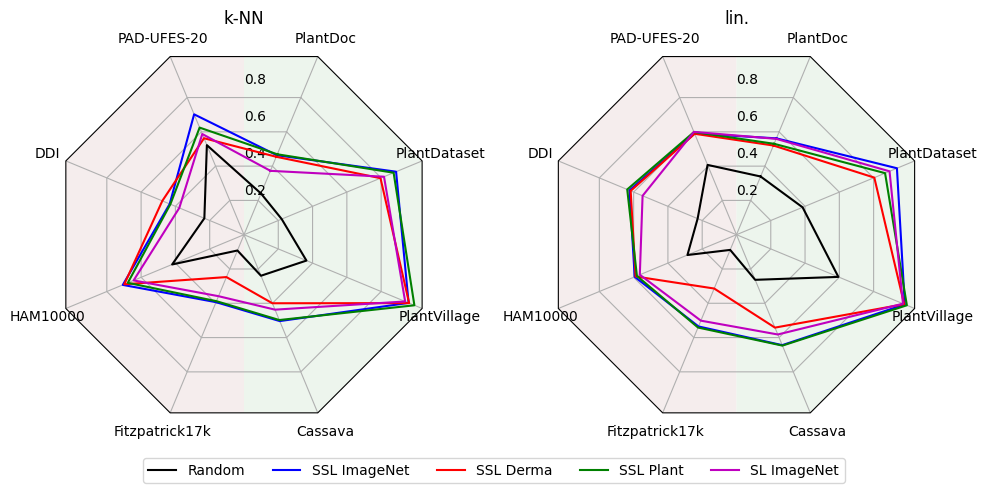

In [69]:

colors = ["black", "b", "r", "g", "m", "y"]

number_of_categories = len(df_plot.columns)
rotation_offset = np.pi / 2 - np.pi / number_of_categories
theta = radar_factory(
    number_of_categories, frame="polygon", rotation_offset=rotation_offset
)

fig, axes = plt.subplots(
    figsize=(10, 5),
    nrows=1,
    ncols=2,
    subplot_kw=dict(projection="radar"),
    squeeze=False,
)

ax = axes.flat[0]
for i, (index, row) in enumerate(df_plot_l.iterrows()):
    color = colors[i] if i < len(colors) else None
    ax.set_theta_offset(rotation_offset)
    ax.plot(theta, row.values, color=color, label=index)
    # ax.fill(theta, row.values, facecolor=color, alpha=0.15) # , label="_nolegend_"

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title("k-NN")
ax.set_varlabels(df_plot_l.columns)
# ax.legend(df_plot_l.index.values, loc=(0.9, 0.95), labelspacing=0.1, fontsize="small")
north = np.pi / 2 - rotation_offset
ax.axvspan(north, np.pi + north, facecolor=(0.95, 0.9, 0.9), alpha=0.7)  # red
ax.axvspan(
    np.pi + north, 2 * np.pi + north, facecolor=(0.9, 0.95, 0.9), alpha=0.7
)  # green

ax = axes.flat[1]
for i, (index, row) in enumerate(df_plot_r.iterrows()):
    color = colors[i] if i < len(colors) else None
    ax.set_theta_offset(rotation_offset)
    ax.plot(theta, row.values, color=color, label=index)
    # ax.fill(theta, row.values, facecolor=color, alpha=0.15) # , label="_nolegend_"

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title("lin.")
ax.set_varlabels(df_plot_r.columns)
# ax.legend(df_plot_r.index.values, loc=(0.9, 0.95), labelspacing=0.1, fontsize="small")
north = np.pi / 2 - rotation_offset
ax.axvspan(north, np.pi + north, facecolor=(0.95, 0.9, 0.9), alpha=0.7)  # red
ax.axvspan(
    np.pi + north, 2 * np.pi + north, facecolor=(0.9, 0.95, 0.9), alpha=0.7
)  # green

lines_labels = [fig.axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.tight_layout()
# fig.legend(lines, labels, loc='lower center', ncol=4)
fig.legend(
    lines, labels, 
    loc="upper center", bbox_to_anchor=(0.5, 0.05)
    , ncol=5
)

# plt.legend(loc=(0.9, 0.8))
postfix = title.lower().replace(" ", "_") + ".png"
plt.savefig(f"../images/spider_{postfix}", bbox_inches="tight")

In [64]:
# df_val = df_model.groupby(["number_of_samples"])
# df_val.columns = df_val.columns.droplevel(0)
# df_val = df_val.reset_index()
# df_val.set_index("number_of_samples", inplace=True)
# df_val = df_val.reindex(index=x_value_order)

# std_err = df_val["std"] / np.sqrt(len(df_val))

In [65]:
# def load_datasets(metric_files):
#     for column, dataset_key in enumerate(dataset_configs):
#         target_columns = [k for k, v in selection_config.items() if v is None]
#         assert 1 == len(
#             target_columns
#         ), f"Invalid configuration. Exactly 1 key should have (None) as value, but there are {len(target_columns)}"
#         dataset_label = dataset_configs[dataset_key]
#         metric_file_path = os.path.join(
#             metric_file_root_path, f"{dataset_key}-metrics.txt"
#         )


# def load_datasets_and_aggregate(metric_file_paths, selection_config):
#     data = []
#     for metric_file_path in metric_file_paths:
#         if len(labels) != len(selected_values):
#             print(df_full["feature_identifier"].unique())
#             print(labels)
#             # assert False, f"Number of values do not match {len(labels)} != {len(selected_values)}"
#         else:
#             data.append(selected_values)
#     df_agg = pd.DataFrame(
#         np.transpose(data).squeeze(), columns=dataset_configs.values()
#     )
#     df_agg.index = labels
#     return df_agg

In [66]:
# df_plot = load_datasets_and_aggregate(dataset_configs, selection_config)

In [67]:
# for filename in os.listdir(metric_file_root_path):
#     if filename.startswith("master-metrics-resnet-"):
#         print(filename)

In [68]:
# def select_and_sort_dataframe(df, selection_config):
#     for selection_key in selection_config:
#         selection_value = selection_config[selection_key]
#         assert (
#             selection_key in df.columns.values
#         ), f"No column found with name {selection_key}"
#         if selection_value is None:
#             continue
#         elif isinstance(selection_value, str):
#             assert (
#                 selection_value in df[selection_key].unique()
#             ), f"No rows matching the given criteria {selection_key}={selection_value}"
#             df = df[df[selection_key] == selection_value]
#         elif hasattr(selection_value, "__iter__"):
#             unique_values = df[selection_key].unique()
#             match_dict = {
#                 unique_value: substring
#                 for substring in selection_value
#                 for unique_value in unique_values
#                 if substring in unique_value
#             }
#             df = df[df[selection_key].isin(match_dict.keys())]
#             df[selection_key] = pd.Categorical(df[selection_key], match_dict.keys())
#         else:
#             print(
#                 f"No implementation for selection {selection_key} with type {type(selection_value)}"
#             )
#         if 0 == len(df):
#             print(f"Key {selection_key} was too harsh")
#             return None
#     return df.sort_values(by=list(selection_config.keys()))

In [69]:
# return_value = select_and_sort_dataframe(df_full.copy(), selection_config)
# return_value

# selected_values = return_value.groupby(group_columns)[target_columns].mean()
# selected_values

# target_columns = [k for k, v in selection_config.items() if v is None]
# target_columns

# group_columns = [
#     k for k in selection_config.keys() if not k == target_columns[0]
# ]
# group_columns